# Imports 

In [202]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime 
from sklearn.model_selection import train_test_split

# Import the autocorrelation function (ACF) plot.
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from sklearn.svm import SVR


from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA

In [6]:
data = pd.read_pickle('clean_daily_oc.pkl')

In [7]:
data.shape

(3651, 14)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3651 entries, 2011-07-31 to 2021-08-17
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   day_of_week_1   3651 non-null   uint8  
 1   day_of_week_2   3651 non-null   uint8  
 2   day_of_week_3   3651 non-null   uint8  
 3   day_of_week_4   3651 non-null   uint8  
 4   day_of_week_5   3651 non-null   uint8  
 5   day_of_week_6   3651 non-null   uint8  
 6   is_holiday_1    3651 non-null   uint8  
 7   Open_pct        3651 non-null   float64
 8   Close_pct       3651 non-null   float64
 9   Volume_diff     3651 non-null   float64
 10  Open_pct_l1     3651 non-null   float64
 11  Close_pct_l1    3651 non-null   float64
 12  Volume_diff_l1  3651 non-null   float64
 13  direction       3651 non-null   object 
dtypes: float64(6), object(1), uint8(7)
memory usage: 253.1+ KB


In [322]:
# define X and y 
X= data.drop(columns=['Open_pct','Close_pct','Volume_diff','direction'])
y= data['Open_pct']

In [323]:
# X.index = pd.DatetimeIndex(X.index).to_period('D')


In [324]:
# test train split 
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,shuffle=False)

In [325]:
# Scale data 
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train)
Xs_test = scaler.transform(X_test)

In [326]:
# check sizes of train and test sets 
Xs_train.shape,Xs_test.shape

((2920, 10), (731, 10))

# Linear Regression 


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [19]:
# Instantiate and fit linreg model 
linreg = LinearRegression().fit(Xs_train,y_train)

In [175]:
def get_metrics(model,X_train=Xs_train,X_test=Xs_test):
    'MSE on unscaled data'
    # get predictions 
    train_preds= model.predict(X_train)
    test_preds= model.predict(X_test)
    # invert back to original scale 
    #inv_train_preds = ss.inverse_transform(train_preds)
    #inv_test_preds = ss.inverse_transform(test_preds)
    # calculate MSE 
    train_mse = mean_squared_error(y_train,train_preds)
    test_mse= mean_squared_error(y_test,test_preds)
    
    print(f'Training MSE: {train_mse}')
    print(f'Testing MSE: {test_mse}')
    print(f'Test - Train(overage): {(test_mse)-(train_mse)}')
    return 

def get_metrics(model):
    # get predictions 
    train_preds= model.predict(Xs_train)
    test_preds= model.predict(Xs_test)
    # invert back to original scale 
    inv_train_preds = ss.inverse_transform(train_preds)
    inv_test_preds = ss.inverse_transform(test_preds)
    # calculate MSE 
    train_mse = mean_squared_error(y_train,inv_train_preds)
    test_mse= mean_squared_error(y_test,inv_test_preds)
    
    print(f'Training MSE: {train_mse}')
    print(f'Testing MSE: {test_mse}')
    print(f'Test - Train(overage): {(test_mse)-(train_mse)}')
    return 

In [45]:
get_metrics(linreg)

Training MSE: 6.340143414696441e-06
Testing MSE: 8.130747996531363e-05
Test - Train(overage): 7.496733655061718e-05


#  Decision Tree 

In [46]:
from sklearn.tree import DecisionTreeRegressor

In [47]:
# instantiate and fit model 
dt= DecisionTreeRegressor(random_state=42,).fit(Xs_train,y_train)

In [48]:
get_metrics(dt)

Training MSE: 9.091757867318713e-07
Testing MSE: 8.055994576502805e-05
Test - Train(overage): 7.965076997829618e-05


In [49]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

# Bagging Regressor  

In [50]:
from sklearn.ensemble import BaggingRegressor

In [51]:
# instantiate and fit model 
bagreg = BaggingRegressor(bootstrap_features=True,random_state=42).fit(Xs_train,y_train)


In [52]:
get_metrics(bagreg)

Training MSE: 5.091393063401981e-06
Testing MSE: 6.52462619564124e-05
Test - Train(overage): 6.0154868893010426e-05


In [53]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

# Random Forest Regressor

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
# instantiate and fit model 
randfor = RandomForestRegressor(random_state=42).fit(Xs_train,y_train)



In [56]:
# get metrics 
get_metrics(randfor)

Training MSE: 1.7713238591330902e-06
Testing MSE: 6.725446609322385e-05
Test - Train(overage): 6.548314223409075e-05


In [57]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

# GradientBoostingRegressor

In [58]:
from sklearn.ensemble import GradientBoostingRegressor

In [59]:
# instantiate and fit model 
gbr = GradientBoostingRegressor(random_state=42,).fit(Xs_train,y_train)

In [61]:
get_metrics(gbr)

Training MSE: 4.40874471535815e-06
Testing MSE: 6.299270715832176e-05
Test - Train(overage): 5.8583962442963614e-05


In [62]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [451]:
# start with full data 
preds_df = data.copy()
# make dataframe with values of predictions to add to preds_df 

In [452]:
preds = gbr.predict(Xs_test)
preds.shape
#start with y_train and add preds to bottom 


(731,)

In [453]:
# make preds into dataframe with index for dates 
preds= pd.Series(preds,index= X_test.index)
# combine preds with y_train 
old_preds = pd.DataFrame(pd.concat([y_train,preds]),columns=['Predictions'])

In [454]:
# make copy of data
df_preds = data.copy()

In [455]:
# add predictions of open_pct to df_preds
df_preds= df_preds.join(old_preds)

In [456]:
# read in dataset with actual prices 
daily = pd.read_csv('./Data/daily.csv')

In [457]:
# testing 
daily['price'][2:].values

array([1292.28, 1286.94, 1254.05, ..., 4468.  , 4479.71, 4448.08])

In [458]:
# add true_price to preds_df 
df_preds['true_price']=daily['price'][2:].values

In [459]:
df_preds.columns

Index(['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'is_holiday_1', 'Open_pct',
       'Close_pct', 'Volume_diff', 'Open_pct_l1', 'Close_pct_l1',
       'Volume_diff_l1', 'direction', 'Predictions', 'true_price'],
      dtype='object')

pct change = (new-old)/old
pct*old+old = new 
new = old(1+pct) 

In [462]:
# get yesterdays price 
last_price= df_preds.loc[df_preds.index[0],'true_price']
# get todays pct change 
change_pct= df_preds.loc[df_preds.index[0+1],'Open_pct']
# get new price 
new_price= last_price*(1+change_pct)

In [463]:
# take out date from index for easier manipulation 
df_preds.reset_index(drop=False,inplace=True)

In [464]:
df_preds.columns

Index(['index', 'date', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'is_holiday_1',
       'Open_pct', 'Close_pct', 'Volume_diff', 'Open_pct_l1', 'Close_pct_l1',
       'Volume_diff_l1', 'direction', 'Predictions', 'true_price'],
      dtype='object')

In [465]:
# get predicted price for each predicted pct_change ('predictions')
price_preds=[]
for i in range(1,len(preds_df)):
    last_price= df_preds.loc[i-1,'true_price']
    change_pct= df_preds.loc[i,'Predictions']
    new_price= last_price*(1+change_pct)
    price_preds.append(new_price)

# true_price vs predicted price 

In [468]:
len(price_preds) # testing 

3650

In [472]:
df_preds[1:].shape # testing 

(3650, 18)

In [474]:
df_preds= df_preds[1:] # drop first so can add price preds 

In [476]:
df_preds.shape

(3649, 18)

In [477]:
# add predicted prices to df_preds
df_preds['pred_price'] = price_preds[1:] # adding one cause shapes dont match can fix later

In [479]:
df_preds[['pred_price','true_price']].head() # confirm worked 

,pred_price,true_price
2,1280.936450,1254.05
3,1222.556384,1260.34
4,1266.349016,1200.07
5,1142.981898,1199.38
6,1198.480650,1199.38


In [490]:
len(preds)

731

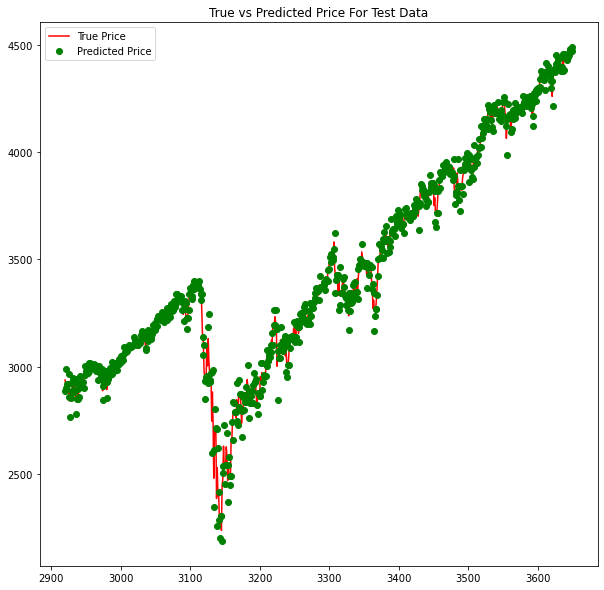

In [511]:
plt.figure(figsize=(10,10))
plt.plot(df_preds['true_price'][-len(preds):],label='True Price',color='red')
plt.plot(df_preds['pred_price'][-len(preds):],'o',label='Predicted Price',color='green',)
plt.title('True vs Predicted Price For Test Data')
plt.legend()

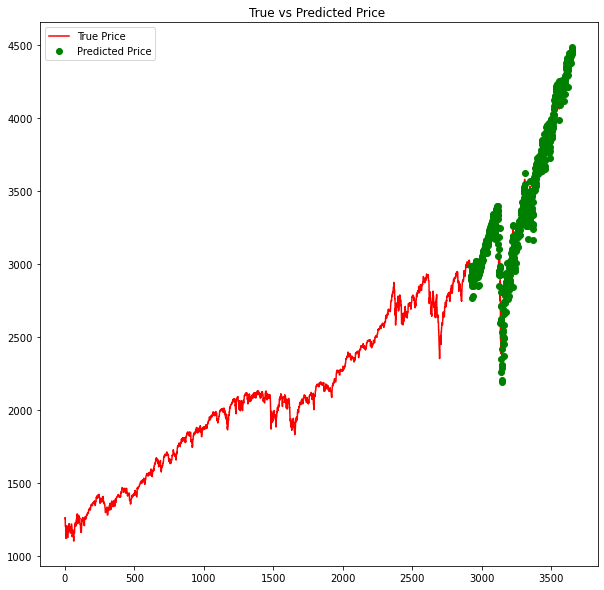

In [512]:
plt.figure(figsize=(10,10))
plt.plot(df_preds['true_price'],label='True Price',color='red')
plt.plot(df_preds['pred_price'][-len(preds):],'o',label='Predicted Price',color='green',)
plt.title('True vs Predicted Price ')
plt.legend()


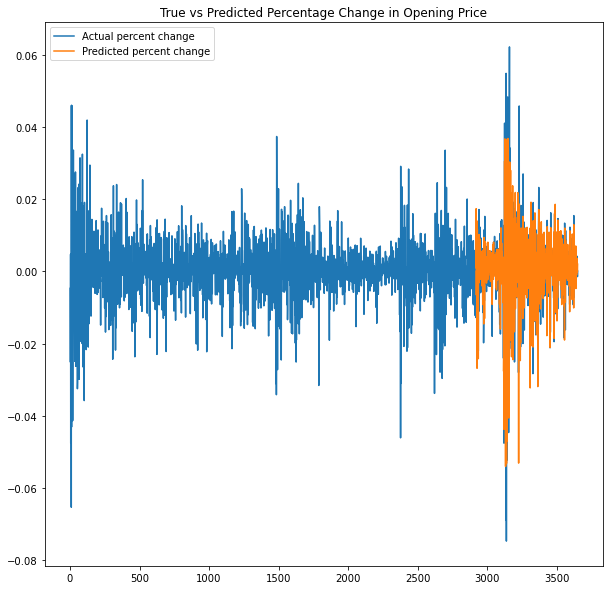

In [514]:
plt.figure(figsize=(10,10))
plt.plot(df_preds['Open_pct'],label='Actual percent change')
plt.plot(df_preds['Predictions'][-len(preds):],label='Predicted percent change')
plt.title('True vs Predicted Percentage Change in Opening Price')
plt.legend()

In [427]:
preds_df['true_price'].head()

date
2011-07-31    1292.28
2011-08-01    1286.94
2011-08-02    1254.05
2011-08-03    1260.34
2011-08-04    1200.07
Name: true_price, dtype: float64

In [399]:
preds_df[['Open_pct','Predictions','true_price']]

,Open_pct,Predictions,true_price
date,,,
2011-07-31,0.000000,0.000000,1292.28
2011-08-01,0.000240,0.000240,1286.94
2011-08-02,-0.004665,-0.004665,1254.05
2011-08-03,-0.025114,-0.025114,1260.34
2011-08-04,0.004768,0.004768,1200.07
...,...,...,...
2021-08-13,0.004219,0.003615,4468.00
2021-08-14,0.000708,0.001025,4468.00
2021-08-15,0.000000,-0.000108,4468.00


In [385]:
daily['preds']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
3648   NaN
3649   NaN
3650   NaN
3651   NaN
3652   NaN
Name: preds, Length: 3653, dtype: float64

In [346]:
gbr.predict(Xs_train).shape

(2920,)

In [403]:
preds = gbr.predict(Xs_train)
preds.shape


(2920,)

# SVM 

In [63]:
from sklearn.svm import SVR

In [64]:
# instantiate and fit model 
svr = SVR().fit(Xs_train,y_train)

In [65]:
get_metrics(svr)

Training MSE: 0.00015126085217047924
Testing MSE: 0.0002188761185762155
Test - Train(overage): 6.761526640573627e-05


In [66]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

# Feed Forward Neural Network 



In [67]:
from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV

In [68]:
Xs_train.shape

(2920, 10)

In [70]:
# model network 

fnn= Sequential()
fnn.add(Dense(128,activation="relu",input_shape=(10,)))
fnn.add(Dense(64, activation="relu"))
fnn.add(Dense(1))
        
# compile model 
fnn.compile(optimizer='adam',loss='mse',)

# check model 
fnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [71]:
validation_data= (Xs_test,y_test)

In [72]:
hist_fnn = fnn.fit(Xs_train,y_train,epochs=100,validation_data=validation_data,
                  shuffle=False)

Epoch 1/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0036
Epoch 2/100
92/92 [==============================] - 0s 1ms/step - loss: 9.6161e-04 - val_loss: 0.0016
Epoch 3/100
92/92 [==============================] - 0s 1ms/step - loss: 2.6436e-04 - val_loss: 0.0011
Epoch 4/100
92/92 [==============================] - 0s 1ms/step - loss: 1.6487e-04 - val_loss: 9.0141e-04
Epoch 5/100
92/92 [==============================] - 0s 1ms/step - loss: 1.2234e-04 - val_loss: 7.8584e-04
Epoch 6/100
92/92 [==============================] - 0s 1ms/step - loss: 1.0179e-04 - val_loss: 7.3596e-04
Epoch 7/100
92/92 [==============================] - 0s 1ms/step - loss: 9.4889e-05 - val_loss: 6.8557e-04
Epoch 8/100
92/92 [==============================] - 0s 1ms/step - loss: 9.5709e-05 - val_loss: 6.6925e-04
Epoch 9/100
92/92 [==============================] - 0s 1ms/step - loss: 8.0669e-05 - val_loss: 6.4678e-04
Epoch 10/100
92/92 [==============================] -

In [73]:
def plot_loss(hist):
    plt.plot(hist.history['loss'], label='Train MSE')
    plt.plot(hist.history['val_loss'], label='Test MSE')
    plt.legend();

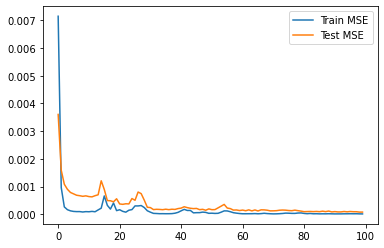

In [74]:
plot_loss(hist_fnn)

In [75]:
get_metrics(fnn)

Training MSE: 1.3602208431510047e-05
Testing MSE: 7.68757353174335e-05
Test - Train(overage): 6.327352688592346e-05


# RNN 

In [76]:
# Create training sequences
train_sequences = TimeseriesGenerator(Xs_train, y_train, length=1,batch_size=64)

# Create Test Sequences
test_sequences = TimeseriesGenerator(Xs_test, y_test, length=1,batch_size=64)

In [77]:
train_sequences[0][0].shape


(64, 1, 10)

In [78]:
input_shape = train_sequences[0][0][0].shape

In [98]:
# model network 

rnn = Sequential()
rnn.add(GRU(20,input_shape=input_shape, return_sequences=True))
rnn.add(GRU(20,return_sequences=False)) # false if next layer dense
rnn.add(Dense(10,activation='relu'))
rnn.add(Dense(1))

# compile model 
rnn.compile(optimizer='adam',loss='mse',)

# show summary 
rnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 1, 20)             1920      
_________________________________________________________________
gru_11 (GRU)                 (None, 20)                2520      
_________________________________________________________________
dense_14 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 4,661
Trainable params: 4,661
Non-trainable params: 0
_________________________________________________________________


In [99]:
hist_rnn = rnn.fit(train_sequences,validation_data=test_sequences,
                  epochs=100,verbose=2)

Epoch 1/100
46/46 - 2s - loss: 3.3713e-04 - val_loss: 1.7230e-04
Epoch 2/100
46/46 - 0s - loss: 7.3781e-05 - val_loss: 1.2915e-04
Epoch 3/100
46/46 - 0s - loss: 6.2896e-05 - val_loss: 1.1744e-04
Epoch 4/100
46/46 - 0s - loss: 6.0641e-05 - val_loss: 1.1579e-04
Epoch 5/100
46/46 - 0s - loss: 5.6046e-05 - val_loss: 1.2263e-04
Epoch 6/100
46/46 - 0s - loss: 5.5678e-05 - val_loss: 1.1894e-04
Epoch 7/100
46/46 - 0s - loss: 5.5554e-05 - val_loss: 1.1636e-04
Epoch 8/100
46/46 - 0s - loss: 5.3298e-05 - val_loss: 1.1731e-04
Epoch 9/100
46/46 - 0s - loss: 5.4253e-05 - val_loss: 1.1815e-04
Epoch 10/100
46/46 - 0s - loss: 5.4630e-05 - val_loss: 1.2185e-04
Epoch 11/100
46/46 - 0s - loss: 5.3919e-05 - val_loss: 1.1295e-04
Epoch 12/100
46/46 - 0s - loss: 5.3152e-05 - val_loss: 1.1773e-04
Epoch 13/100
46/46 - 0s - loss: 5.3391e-05 - val_loss: 1.1549e-04
Epoch 14/100
46/46 - 0s - loss: 5.2585e-05 - val_loss: 1.2013e-04
Epoch 15/100
46/46 - 0s - loss: 5.4121e-05 - val_loss: 1.1871e-04
Epoch 16/100
46/46 

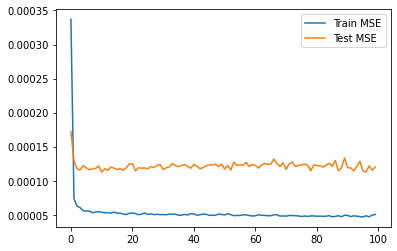

In [100]:
plot_loss(hist_rnn)

In [84]:
# get_metrics(rnn) 

# LSTM 



In [85]:
Xs_train.shape

(2920, 10)

In [88]:
# reshape for LSTM layers 
X_train_lstm= np.reshape(Xs_train,(Xs_train.shape[0],1,Xs_train.shape[1]))
X_test_lstm = np.reshape(Xs_test,(Xs_test.shape[0],1,Xs_test.shape[1]))

In [89]:
X_train_lstm.shape

(2920, 1, 10)

In [90]:
X_test_lstm.shape

(731, 1, 10)

In [331]:
# model network 

lstm = Sequential()
lstm.add(LSTM(30,input_shape=(1,10)))
lstm.add(Dense(20,activation='relu'))
lstm.add(Dense(1))
# compile model 
lstm.compile(optimizer='adam',loss='mse',)

lstm.summary()

Model: "sequential_209"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_202 (LSTM)              (None, 30)                4920      
_________________________________________________________________
dense_409 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_410 (Dense)            (None, 1)                 21        
Total params: 5,561
Trainable params: 5,561
Non-trainable params: 0
_________________________________________________________________


In [332]:
# fit model 
hist_lstm = lstm.fit(X_train_lstm,y_train,
                     validation_data=(X_test_lstm,y_test),
                  epochs=100,verbose=2)

Epoch 1/100
92/92 - 1s - loss: 6.2142e-04 - val_loss: 3.8211e-04
Epoch 2/100
92/92 - 0s - loss: 6.3273e-05 - val_loss: 2.1640e-04
Epoch 3/100
92/92 - 0s - loss: 3.2210e-05 - val_loss: 1.5745e-04
Epoch 4/100
92/92 - 0s - loss: 2.3225e-05 - val_loss: 1.2622e-04
Epoch 5/100
92/92 - 0s - loss: 1.9654e-05 - val_loss: 1.1105e-04
Epoch 6/100
92/92 - 0s - loss: 1.6650e-05 - val_loss: 1.0597e-04
Epoch 7/100
92/92 - 0s - loss: 1.3865e-05 - val_loss: 9.6254e-05
Epoch 8/100
92/92 - 0s - loss: 1.3051e-05 - val_loss: 9.7491e-05
Epoch 9/100
92/92 - 0s - loss: 1.3075e-05 - val_loss: 9.7121e-05
Epoch 10/100
92/92 - 0s - loss: 1.3245e-05 - val_loss: 8.5103e-05
Epoch 11/100
92/92 - 0s - loss: 1.1671e-05 - val_loss: 8.3372e-05
Epoch 12/100
92/92 - 0s - loss: 1.1048e-05 - val_loss: 9.4790e-05
Epoch 13/100
92/92 - 0s - loss: 1.2295e-05 - val_loss: 9.9154e-05
Epoch 14/100
92/92 - 0s - loss: 1.0967e-05 - val_loss: 9.3234e-05
Epoch 15/100
92/92 - 0s - loss: 1.0365e-05 - val_loss: 8.0010e-05
Epoch 16/100
92/92 

In [333]:
pd.DataFrame(hist_lstm.history).sort_values(by='val_loss')

,loss,val_loss
82,0.000007,0.000069
94,0.000007,0.000074
99,0.000007,0.000076
80,0.000007,0.000077
79,0.000007,0.000077
...,...,...
29,0.000010,0.000120
3,0.000023,0.000126
2,0.000032,0.000157
1,0.000063,0.000216


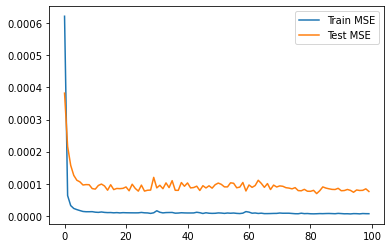

In [334]:
plot_loss(hist_lstm)

In [337]:
get_metrics(lstm,X_train_lstm,X_test_lstm)

Training MSE: 7.162298833787815e-06
Testing MSE: 7.606285853361118e-05
Test - Train(overage): 6.890055969982336e-05


In [ ]:
validation_data=(X_test_lstm,y_test)

In [179]:
# get_metrics(lstm,X_train=X_train_lstm,X_test=X_test_lstm) FIX THIS 

In [285]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return




## Baysian Search 

In [107]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:
Integer()

In [241]:
# function to make models 
def func_lstm_model(nodes_lstm,nodes_dense):
    model = Sequential()
    model.add(LSTM(nodes_lstm,input_shape=(1,10)))
    model.add(Dense(nodes_dense,activation='relu'))
    model.add(Dense(1,))
    model.compile(optimizer='adam',loss='mse')
    return model 

In [242]:
lstm_modeler = KerasRegressor(build_fn=func_lstm_model,epochs=50,verbose=1)

In [247]:
search_space_lstm = {
    'nodes_lstm':Integer(10,100),
    'nodes_dense':Integer(10,100)
}


In [248]:
lstm_bs1 = BayesSearchCV(lstm_modeler,search_space_lstm,n_iter=500,random_state=42,verbose=2,)

In [249]:
lstm_bs1.fit(X_train_lstm,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] nodes_dense=47, nodes_lstm=75 ...................................
Epoch 1/50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


73/73 [==============================] - 1s 3ms/step - loss: 2.7173e-04 - mse: 2.7173e-04
Epoch 2/50
73/73 [==============================] - 0s 3ms/step - loss: 2.6232e-05 - mse: 2.6232e-05
Epoch 3/50
73/73 [==============================] - 0s 3ms/step - loss: 1.8050e-05 - mse: 1.8050e-05
Epoch 4/50
73/73 [==============================] - 0s 3ms/step - loss: 1.4511e-05 - mse: 1.4511e-05
Epoch 5/50
73/73 [==============================] - 0s 3ms/step - loss: 1.4009e-05 - mse: 1.4009e-05
Epoch 6/50
73/73 [==============================] - 0s 3ms/step - loss: 1.4109e-05 - mse: 1.4109e-05
Epoch 7/50
73/73 [==============================] - 0s 3ms/step - loss: 1.2830e-05 - mse: 1.2830e-05
Epoch 8/50
73/73 [==============================] - 0s 3ms/step - loss: 1.3139e-05 - mse: 1.3139e-05
Epoch 9/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1226e-05 - mse: 1.1226e-05
Epoch 10/50
73/73 [==============================] - 0s 3ms/step - loss: 1.0733e-05 - mse: 1.0733e-05


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s


Epoch 1/50
73/73 [==============================] - 1s 3ms/step - loss: 2.6328e-04 - mse: 2.6328e-04
Epoch 2/50
73/73 [==============================] - 0s 3ms/step - loss: 2.4359e-05 - mse: 2.4359e-05
Epoch 3/50
73/73 [==============================] - 0s 3ms/step - loss: 1.5980e-05 - mse: 1.5980e-05
Epoch 4/50
73/73 [==============================] - 0s 3ms/step - loss: 1.3496e-05 - mse: 1.3496e-05
Epoch 5/50
73/73 [==============================] - 0s 3ms/step - loss: 1.3045e-05 - mse: 1.3045e-05
Epoch 6/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1662e-05 - mse: 1.1662e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0960e-05 - mse: 1.0960e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2678e-05 - mse: 1.2678e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3791e-05 - mse: 1.3791e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3113e-05 - mse: 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   53.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/50
73/73 [==============================] - 1s 3ms/step - loss: 2.5654e-04 - mse: 2.5654e-04
Epoch 2/50
73/73 [==============================] - 0s 3ms/step - loss: 2.0155e-05 - mse: 2.0155e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4503e-05 - mse: 1.4503e-05
Epoch 4/50
73/73 [==============================] - 0s 3ms/step - loss: 1.2887e-05 - mse: 1.2887e-05
Epoch 5/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1361e-05 - mse: 1.1361e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1168e-05 - mse: 1.1168e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2173e-05 - mse: 1.2173e-05
Epoch 8/50
73/73 [==============================] - 0s 3ms/step - loss: 1.2123e-05 - mse: 1.2123e-05
Epoch 9/50
73/73 [==============================] - 0s 3ms/step - loss: 1.2987e-05 - mse: 1.2987e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0809e-05 - mse: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s


73/73 [==============================] - 1s 3ms/step - loss: 2.6028e-04 - mse: 2.6028e-04
Epoch 2/50
73/73 [==============================] - 0s 3ms/step - loss: 2.2810e-05 - mse: 2.2810e-05
Epoch 3/50
73/73 [==============================] - 0s 3ms/step - loss: 1.5588e-05 - mse: 1.5588e-05
Epoch 4/50
73/73 [==============================] - 0s 3ms/step - loss: 1.2665e-05 - mse: 1.2665e-05
Epoch 5/50
73/73 [==============================] - 0s 3ms/step - loss: 1.4110e-05 - mse: 1.4110e-05
Epoch 6/50
73/73 [==============================] - 0s 3ms/step - loss: 1.3595e-05 - mse: 1.3595e-05
Epoch 7/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1759e-05 - mse: 1.1759e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4798e-05 - mse: 1.4798e-05
Epoch 9/50
73/73 [==============================] - 0s 3ms/step - loss: 1.7264e-05 - mse: 1.7264e-05
Epoch 10/50
73/73 [==============================] - 0s 3ms/step - loss: 1.7766e-05 - mse: 1.7766e-05


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   56.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


73/73 [==============================] - 1s 3ms/step - loss: 1.7825e-04 - mse: 1.7825e-04
Epoch 2/50
73/73 [==============================] - 0s 3ms/step - loss: 2.5796e-05 - mse: 2.5796e-05
Epoch 3/50
73/73 [==============================] - 0s 3ms/step - loss: 1.8903e-05 - mse: 1.8903e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.5189e-05 - mse: 1.5189e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3962e-05 - mse: 1.3962e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4275e-05 - mse: 1.4275e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4672e-05 - mse: 1.4672e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3755e-05 - mse: 1.3755e-05
Epoch 9/50
73/73 [==============================] - 0s 3ms/step - loss: 1.3406e-05 - mse: 1.3406e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.7784e-05 - mse: 1.7784e-05


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


73/73 [==============================] - 1s 2ms/step - loss: 2.0591e-04 - mse: 2.0591e-04
Epoch 2/50
73/73 [==============================] - 0s 3ms/step - loss: 2.5179e-05 - mse: 2.5179e-05
Epoch 3/50
73/73 [==============================] - 0s 3ms/step - loss: 1.7319e-05 - mse: 1.7319e-05
Epoch 4/50
73/73 [==============================] - 0s 3ms/step - loss: 1.3768e-05 - mse: 1.3768e-05
Epoch 5/50
73/73 [==============================] - 0s 3ms/step - loss: 1.4802e-05 - mse: 1.4802e-05
Epoch 6/50
73/73 [==============================] - 0s 3ms/step - loss: 1.3244e-05 - mse: 1.3244e-05
Epoch 7/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1402e-05 - mse: 1.1402e-05
Epoch 8/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1425e-05 - mse: 1.1425e-05
Epoch 9/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1138e-05 - mse: 1.1138e-05
Epoch 10/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1014e-05 - mse: 1.1014e-05


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


73/73 [==============================] - 1s 2ms/step - loss: 3.8383e-04 - mse: 3.8383e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 3.6990e-05 - mse: 3.6990e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 2.1075e-05 - mse: 2.1075e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.5795e-05 - mse: 1.5795e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.3334e-05 - mse: 1.3334e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1093e-05 - mse: 1.1093e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0003e-05 - mse: 1.0003e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0095e-05 - mse: 1.0095e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 9.3988e-06 - mse: 9.3988e-06
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 9.4159e-06 - mse: 9.4159e-06


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


Epoch 1/50
73/73 [==============================] - 1s 3ms/step - loss: 2.8946e-04 - mse: 2.8946e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 3.5397e-05 - mse: 3.5397e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 2.2521e-05 - mse: 2.2521e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.6192e-05 - mse: 1.6192e-05
Epoch 5/50
73/73 [==============================] - 0s 3ms/step - loss: 1.3467e-05 - mse: 1.3467e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2180e-05 - mse: 1.2180e-05
Epoch 7/50
73/73 [==============================] - 0s 2ms/step - loss: 1.1210e-05 - mse: 1.1210e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0889e-05 - mse: 1.0889e-05
Epoch 9/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0439e-05 - mse: 1.0439e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0831e-05 - mse: 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   53.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


73/73 [==============================] - 1s 3ms/step - loss: 3.5888e-04 - mse: 3.5888e-04
Epoch 2/50
73/73 [==============================] - 0s 3ms/step - loss: 2.3193e-05 - mse: 2.3193e-05
Epoch 3/50
73/73 [==============================] - 0s 3ms/step - loss: 1.5315e-05 - mse: 1.5315e-05
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2915e-05 - mse: 1.2915e-05
Epoch 5/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1564e-05 - mse: 1.1564e-05
Epoch 6/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1019e-05 - mse: 1.1019e-05
Epoch 7/50
73/73 [==============================] - 0s 3ms/step - loss: 1.0226e-05 - mse: 1.0226e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 9.7870e-06 - mse: 9.7870e-06
Epoch 9/50
73/73 [==============================] - 0s 3ms/step - loss: 9.6068e-06 - mse: 9.6068e-06
Epoch 10/50
73/73 [==============================] - 0s 3ms/step - loss: 9.7603e-06 - mse: 9.7603e-06


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s


73/73 [==============================] - 1s 2ms/step - loss: 3.1551e-04 - mse: 3.1551e-04
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 2.9871e-05 - mse: 2.9871e-05
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 2.0273e-05 - mse: 2.0273e-05
Epoch 4/50
73/73 [==============================] - 0s 3ms/step - loss: 1.5499e-05 - mse: 1.5499e-05
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 1.4423e-05 - mse: 1.4423e-05
Epoch 6/50
73/73 [==============================] - 0s 2ms/step - loss: 1.2218e-05 - mse: 1.2218e-05
Epoch 7/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1778e-05 - mse: 1.1778e-05
Epoch 8/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0946e-05 - mse: 1.0946e-05
Epoch 9/50
73/73 [==============================] - 0s 3ms/step - loss: 1.0750e-05 - mse: 1.0750e-05
Epoch 10/50
73/73 [==============================] - 0s 2ms/step - loss: 1.0932e-05 - mse: 1.0932e-05


KeyboardInterrupt: 

In [297]:
pd.DataFrame(lstm_bs1.cv_results_)[['params','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

,params,mean_test_score
1,"{'nodes_dense': 85, 'nodes_lstm': 89}",-0.000010
2,"{'nodes_dense': 50, 'nodes_lstm': 93}",-0.000011
0,"{'nodes_dense': 47, 'nodes_lstm': 75}",-0.000011
3,"{'nodes_dense': 83, 'nodes_lstm': 25}",-0.000011


In [340]:
lstm_best= Sequential()
lstm_best.add(LSTM(89,input_shape=(1,10)))
lstm_best.add(Dense(85,activation='relu'))
lstm_best.add(Dense(1))

lstm_best.compile(optimizer='adam',loss='mse')

hist_best_lstm = lstm_best.fit(X_train_lstm,y_train,
                     validation_data=(X_test_lstm,y_test),
                  epochs=100,verbose=2)

Epoch 1/100
92/92 - 1s - loss: 1.8765e-04 - val_loss: 1.1793e-04
Epoch 2/100
92/92 - 0s - loss: 1.9785e-05 - val_loss: 1.0712e-04
Epoch 3/100
92/92 - 0s - loss: 1.8946e-05 - val_loss: 1.3429e-04
Epoch 4/100
92/92 - 0s - loss: 1.5783e-05 - val_loss: 1.0494e-04
Epoch 5/100
92/92 - 0s - loss: 1.6972e-05 - val_loss: 1.0322e-04
Epoch 6/100
92/92 - 0s - loss: 1.3546e-05 - val_loss: 9.5902e-05
Epoch 7/100
92/92 - 0s - loss: 2.2559e-05 - val_loss: 8.5713e-05
Epoch 8/100
92/92 - 0s - loss: 1.5788e-05 - val_loss: 1.2617e-04
Epoch 9/100
92/92 - 0s - loss: 3.4061e-05 - val_loss: 1.0279e-04
Epoch 10/100
92/92 - 0s - loss: 3.2420e-05 - val_loss: 9.7006e-05
Epoch 11/100
92/92 - 0s - loss: 3.1259e-05 - val_loss: 9.7881e-05
Epoch 12/100
92/92 - 0s - loss: 2.1405e-05 - val_loss: 9.8087e-05
Epoch 13/100
92/92 - 0s - loss: 1.4043e-05 - val_loss: 9.9858e-05
Epoch 14/100
92/92 - 0s - loss: 1.6520e-05 - val_loss: 9.1024e-05
Epoch 15/100
92/92 - 0s - loss: 1.1546e-05 - val_loss: 9.4924e-05
Epoch 16/100
92/92 

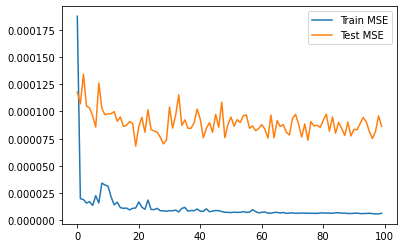

In [342]:
plt.plot(hist_best_lstm.history['loss'],label='Train MSE')
plt.plot(hist_best_lstm.history['val_loss'],label='Test MSE')
plt.legend()

In [343]:
get_metrics(lstm_best,X_train_lstm,X_test_lstm)

Training MSE: 5.450667336522919e-06
Testing MSE: 8.634419844482044e-05
Test - Train(overage): 8.089353110829752e-05


In [311]:
X_train_lstm.shape

(2920, 1, 10)

In [320]:
preds = lstm_best(X_train_lstm)
preds.shape

TensorShape([2920, 3])

In [329]:
X_train_lstm.shape

(2920, 1, 10)

In [330]:
y_train

date
2011-07-31    0.000000
2011-08-01    0.000240
2011-08-02   -0.004665
2011-08-03   -0.025114
2011-08-04    0.004768
                ...   
2019-08-03   -0.004025
2019-08-04    0.000000
2019-08-05   -0.011589
2019-08-06   -0.012729
2019-08-07   -0.000884
Name: Open_pct, Length: 2920, dtype: float64

In [327]:
np.reshape(preds,())

ValueError: operands could not be broadcast together with shapes (2920,3) (10,) (2920,3) 

In [314]:
# reshape for LSTM layers 
X_train_lstm= np.reshape(Xs_train,(Xs_train.shape[0],1,Xs_train.shape[1]))
X_test_lstm = np.reshape(Xs_test,(Xs_test.shape[0],1,Xs_test.shape[1]))

date
2011-07-31    0.000000
2011-08-01    0.000240
2011-08-02   -0.004665
2011-08-03   -0.025114
2011-08-04    0.004768
                ...   
2019-08-03   -0.004025
2019-08-04    0.000000
2019-08-05   -0.011589
2019-08-06   -0.012729
2019-08-07   -0.000884
Name: Open_pct, Length: 2920, dtype: float64

In [ ]:
lstm_best= Sequential()
lstm_best.add(LSTM(89,input_shape=(1,10)))
lstm_best.add(Dense(85,activation='relu'))
lstm_best.add(Dense(3))

lstm_best.compile(optimizer='adam',loss='mse')

hist_best_lstm = lstm_best.fit(X_train_lstm,y_train,
                     validation_data=(X_test_lstm,y_test),
                  epochs=100,verbose=2)

## Randomized Search 


In [148]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [149]:
# function to make models 
def func_lstm_model(nodes_lstm,nodes_dense):
    model = Sequential()
    model.add(LSTM(nodes_lstm,input_shape=(1,10)))
    model.add(Dense(nodes_dense,activation='relu'))
    model.add(Dense(3,))
    model.compile(optimizer='adam',loss='mse',)
    return model 

In [155]:
lstm_modeler = KerasRegressor(build_fn=func_lstm_model,epochs=50,verbose=0)

In [156]:
# params = 
params_rs_lstm1 = {
    'nodes_lstm': randint(10,100),
    'nodes_dense': randint(10,100)
}

rs_lstm_1 = RandomizedSearchCV(lstm_modeler,params_rs_lstm1,n_iter=50,random_state=42,verbose=2,cv=2)

# fit 
rs_lstm_1.fit(X_train_lstm,y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] nodes_dense=61, nodes_lstm=24 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... nodes_dense=61, nodes_lstm=24, total=   5.8s
[CV] nodes_dense=61, nodes_lstm=24 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV] .................... nodes_dense=61, nodes_lstm=24, total=   6.6s
[CV] nodes_dense=81, nodes_lstm=70 ...................................
[CV] .................... nodes_dense=81, nodes_lstm=70, total=   6.7s
[CV] nodes_dense=81, nodes_lstm=70 ...................................
[CV] .................... nodes_dense=81, nodes_lstm=70, total=   6.6s
[CV] nodes_dense=30, nodes_lstm=92 ...................................
[CV] .................... nodes_dense=30, nodes_lstm=92, total=   6.3s
[CV] nodes_dense=30, nodes_lstm=92 ...................................
[CV] .................... nodes_dense=30, nodes_lstm=92, total=   6.1s
[CV] nodes_dense=96, nodes_lstm=84 ...................................
[CV] .................... nodes_dense=96, nodes_lstm=84, total=   6.1s
[CV] nodes_dense=96, nodes_lstm=84 ...................................
[CV] .................... nodes_dense=96, nodes_lstm=84, total=   6.1s
[CV] nodes_dense=84, nodes_lstm=97 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 11.1min finished


RandomizedSearchCV(cv=2,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd79c104f40>,
                   n_iter=50,
                   param_distributions={'nodes_dense': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd8e6d2e580>,
                                        'nodes_lstm': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd8086a5f40>},
                   random_state=42, verbose=2)

In [160]:
def rs_results(rs):
    return pd.DataFrame(rs.cv_results_)[['params','mean_test_score']].sort_values(by='mean_test_score',ascending=False).head(10)

In [161]:
rs_results(rs_lstm_1)

,params,mean_test_score
27,"{'nodes_dense': 11, 'nodes_lstm': 93}",-0.000011
34,"{'nodes_dense': 15, 'nodes_lstm': 63}",-0.000011
35,"{'nodes_dense': 13, 'nodes_lstm': 63}",-0.000011
11,"{'nodes_dense': 42, 'nodes_lstm': 85}",-0.000012
7,"{'nodes_dense': 11, 'nodes_lstm': 97}",-0.000012
20,"{'nodes_dense': 12, 'nodes_lstm': 60}",-0.000012
2,"{'nodes_dense': 30, 'nodes_lstm': 92}",-0.000012
32,"{'nodes_dense': 45, 'nodes_lstm': 59}",-0.000012
22,"{'nodes_dense': 82, 'nodes_lstm': 48}",-0.000012
43,"{'nodes_dense': 49, 'nodes_lstm': 94}",-0.000012


In [256]:
# Make model with best params from search 

# model network 

lstm_2 = Sequential()
lstm_2.add(LSTM(93,input_shape=(1,10)))
lstm_2.add(Dense(11))

# compile model 
lstm_2.compile(optimizer='adam',loss='mse',)

lstm_2.summary()


Model: "sequential_207"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_200 (LSTM)              (None, 93)                38688     
_________________________________________________________________
dense_406 (Dense)            (None, 11)                1034      
Total params: 39,722
Trainable params: 39,722
Non-trainable params: 0
_________________________________________________________________


In [257]:
# fit model 
hist_lstm_2 = lstm_2.fit(X_train_lstm,y_train,
                     validation_data=(X_test_lstm,y_test),
                  epochs=100,verbose=2)

Epoch 1/100
92/92 - 1s - loss: 4.6145e-04 - val_loss: 2.0208e-04
Epoch 2/100
92/92 - 0s - loss: 2.4926e-05 - val_loss: 1.3471e-04
Epoch 3/100
92/92 - 0s - loss: 1.5794e-05 - val_loss: 1.1727e-04
Epoch 4/100
92/92 - 0s - loss: 1.2401e-05 - val_loss: 1.1116e-04
Epoch 5/100
92/92 - 0s - loss: 1.0996e-05 - val_loss: 9.8138e-05
Epoch 6/100
92/92 - 0s - loss: 1.0215e-05 - val_loss: 1.0801e-04
Epoch 7/100
92/92 - 0s - loss: 9.5859e-06 - val_loss: 9.8439e-05
Epoch 8/100
92/92 - 0s - loss: 9.1656e-06 - val_loss: 1.0408e-04
Epoch 9/100
92/92 - 0s - loss: 8.9354e-06 - val_loss: 1.0465e-04
Epoch 10/100
92/92 - 0s - loss: 8.6175e-06 - val_loss: 9.9037e-05
Epoch 11/100
92/92 - 0s - loss: 8.5154e-06 - val_loss: 8.8224e-05
Epoch 12/100
92/92 - 0s - loss: 8.3198e-06 - val_loss: 9.4811e-05
Epoch 13/100
92/92 - 0s - loss: 8.7623e-06 - val_loss: 8.3110e-05
Epoch 14/100
92/92 - 0s - loss: 8.5686e-06 - val_loss: 8.7850e-05
Epoch 15/100
92/92 - 0s - loss: 8.0437e-06 - val_loss: 9.4911e-05
Epoch 16/100
92/92 

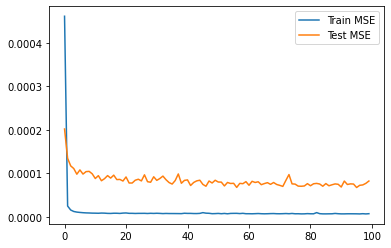

In [258]:
plot_loss(hist_lstm_2)

In [266]:
y_train.shape

(2920,)

In [264]:
lstm_2(X_train_lstm).shape


TensorShape([2920, 11])

In [262]:
mean_squared_error(y_train,lstm_2.predict_classes(X_train_lstm))

/home/tanveer/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


25.020366608530807

In [ ]:
rs_lstm_1

In [163]:
pd.DataFrame(rs_lstm_1.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_nodes_dense', 'param_nodes_lstm', 'params', 'split0_test_score',
       'split1_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

<AxesSubplot:xlabel='param_nodes_dense', ylabel='mean_test_score'>

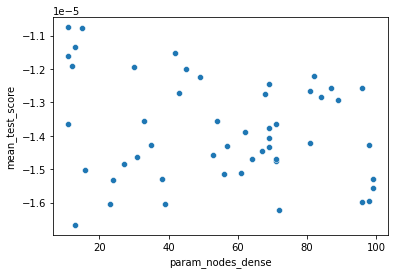

In [171]:
sns.scatterplot(x=pd.DataFrame(rs_lstm_1.cv_results_)['param_nodes_dense'],y=pd.DataFrame(rs_lstm_1.cv_results_)['mean_test_score'])

<AxesSubplot:xlabel='param_nodes_lstm', ylabel='mean_test_score'>

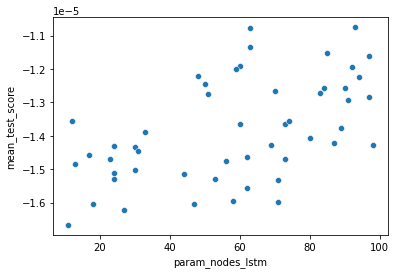

In [172]:
sns.scatterplot(x=pd.DataFrame(rs_lstm_1.cv_results_)['param_nodes_lstm'],y=pd.DataFrame(rs_lstm_1.cv_results_)['mean_test_score'])

In [173]:
# plot on same axis 

In [180]:
# get_metrics(rs_lstm_1)

In [221]:
X_train

,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_holiday_1,Open_pct_l1,Close_pct_l1,Volume_diff_l1
date,,,,,,,,,,
2011-07-31,0,0,0,0,0,1,0,-0.006030,0.000000,-5.061190e+09
2011-08-01,0,0,0,0,0,0,0,0.000000,0.000000,0.000000e+00
2011-08-02,1,0,0,0,0,0,0,0.000240,-0.004132,4.967390e+09
2011-08-03,0,1,0,0,0,0,0,-0.004665,-0.025557,2.389000e+08
2011-08-04,0,0,1,0,0,0,0,-0.025114,0.005016,1.240650e+09
...,...,...,...,...,...,...,...,...,...,...
2019-08-03,0,0,0,0,1,0,0,-0.012220,-0.007283,-8.876400e+08
2019-08-04,0,0,0,0,0,1,0,-0.004025,0.000000,-3.874660e+09
2019-08-05,0,0,0,0,0,0,0,0.000000,0.000000,0.000000e+00


# ARIMA  

In [187]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller # ADFuller Hypothesis test
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima

In [191]:
y

date
2011-07-31    0.000000
2011-08-01    0.000240
2011-08-02   -0.004665
2011-08-03   -0.025114
2011-08-04    0.004768
                ...   
2021-08-13    0.004219
2021-08-14    0.000708
2021-08-15    0.000000
2021-08-16   -0.001421
2021-08-17    0.000105
Name: Open_pct, Length: 3651, dtype: float64

In [228]:
arima_search1 = auto_arima(y_train,X_train,
                          start_p=0,
                          start_P=0,
                          start_q=0,
                          start_Q=0,
                          max_d=5,
                          max_D=5,
                          max_P=5,
                          max_p=5,
                          max_q=5,
                          max_Q=5,
                        max_order=None,
                          seasonal=False,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6256.597, Time=1.26 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-27212.876, Time=1.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-27347.369, Time=1.19 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-27351.217, Time=1.44 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-27355.878, Time=1.53 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-27349.916, Time=1.61 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-27353.923, Time=2.61 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-27350.768, Time=2.73 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-27348.217, Time=2.35 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-27356.214, Time=2.22 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-27354.256, Time=1.89 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-27352.132, Time=2.43 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-27355.813, Time=1.96 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 24.371 seco

/home/tanveer/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


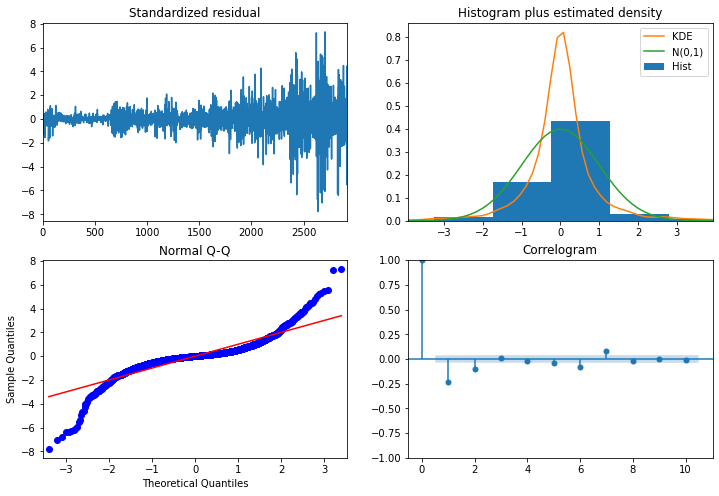

In [198]:
arima_search1.plot_diagnostics(figsize=(12,8));

In [199]:
arima_search1 = auto_arima(y_train,Xs_train,
                          #start_p=0,
                          #start_P=0,
                          #start_q=0,
                          #start_Q=0,
                          max_d=5,
                          max_D=5,
                          max_P=5,
                          max_p=5,
                          max_q=5,
                          max_Q=5,
                        max_order=None,
                          seasonal=False,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-27429.711, Time=4.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-26598.920, Time=1.87 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-27239.204, Time=2.36 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-27429.474, Time=1.81 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-27462.215, Time=7.39 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-27427.851, Time=1.73 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-27424.862, Time=3.20 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-27432.940, Time=2.47 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-27437.472, Time=2.80 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-27434.800, Time=5.39 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-27426.221, Time=4.30 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-27716.531, Time=3.23 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-27713.898, Time=2.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-27719.817, Time=4.08 sec
 ARIM

In [215]:
arima_search1 = auto_arima(y_train,Xs_train,
                          start_p=5,
                          start_P=5,
                          start_q=5,
                          start_Q=5,
                          max_d=50,
                          max_D=50,
                          max_P=50,
                          max_p=50,
                          max_q=50,
                          max_Q=50,
                        max_order=None,
                          seasonal=False,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,)

Performing stepwise search to minimize aic
 ARIMA(5,0,5)(0,0,0)[0]             : AIC=-26578.982, Time=7.53 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-26598.920, Time=1.87 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-27239.204, Time=2.73 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-27429.474, Time=1.63 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-27424.862, Time=3.46 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-27427.851, Time=2.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-27462.215, Time=5.82 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-27429.711, Time=5.50 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-27432.940, Time=2.37 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-27437.472, Time=2.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-27434.800, Time=6.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-27426.221, Time=4.94 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-27716.531, Time=3.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-27713.898, Time=2.14 sec
 ARIM

# ARIMAX 

In [210]:
arimax1 = ARIMA(endog=y_train,exog=Xs_train,order())

/home/tanveer/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/tanveer/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/tanveer/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [211]:
arimax1_results = arimax1.fit()

In [212]:
arimax1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Open_pct   No. Observations:                 2920
Model:                          ARIMA   Log Likelihood               13330.783
Date:                Thu, 26 Aug 2021   AIC                         -26637.567
Time:                        22:53:59   BIC                         -26565.815
Sample:                             0   HQIC                        -26611.722
                               - 2920                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   9.99e-05      2.936      0.003    9.75e-05       0.000
x1            -0.0001   7.68e-05     -1.543      0.123      -0.000     3.2e-05
x2         -6.498e-05   5.91e-05     -1.100      0.271      -0.000    5.08e-05
x3            -0.0001   5.94e-05     -2.271      0.023      -0.000   -1.85e-05
x4          2.289e-05   5.75e-05      0.398      0.691   -8.98e-05       0.000
x5            -0.0001   7.09e-05     -1.701      0.089      -0.000    1.84e-05
x6         -4.373e-05      0.000     -0.196      0.845      -0.000       0.000
x7         -4.405e-05      0.000     -0.380      0.704      -0.000       0.000
x8            -0.0004   3.02e-05    -12.164      0.000      -0.000      -0.000
x9             0.0068    3.1e-05    218.814      0.000       0.007       0.007
x10         6.933e-05      8e-05      0.866      0.386   -8.75e-05       0.000
sigma2       6.36e-06   7.18e-08     88.617      0.000    6.22e-06     6.5e-06
===================================================================================
Ljung-Box (L1) (Q):                 517.07   Jarque-Bera (JB):             12937.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              11.06   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [213]:
arimax1_results.model_orders

{'trend': 0,
 'exog': 11,
 'ar': 0,
 'ma': 0,
 'seasonal_ar': 0,
 'seasonal_ma': 0,
 'reduced_ar': 0,
 'reduced_ma': 0,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

There is a trend so ARIMA not useful 

# Exponential Smoothing 

In [216]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt


In [217]:
holt1 = Holt(endog=y_train,)

/home/tanveer/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/tanveer/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [267]:
holt1_results = holt1.fit(smoothing_level=.3, smoothing_slope=.05,optimized=True)
holt1_results.summary()

<ipython-input-267-f7efb98d141e>:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  holt1_results = holt1.fit(smoothing_level=.3, smoothing_slope=.05,optimized=True)


Dep. Variable:,Open_pct,No. Observations:,2920
Model:,Holt,SSE,0.186
Optimized:,True,AIC,-28197.946
Trend:,Additive,BIC,-28174.028
Seasonal:,None,AICC,-28197.917
Seasonal Periods:,None,Date:,"Fri, 27 Aug 2021"
Box-Cox:,False,Time:,00:51:14
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3000000,alpha,False
smoothing_trend,0.0500000,beta,False


In [270]:
y_train.values

array([ 0.        ,  0.00023984, -0.00466498, ..., -0.01158915,
       -0.01272921, -0.00088426])

In [272]:
holt1_results.aic

-28197.945567260882

In [276]:
# gridsearch over values for level, slope, damping between 0-1 
smoothing_levels = [0.01,0.1,0.2,0.4,0.8]
smoothing_slope= [0.01,0.1,0.2,0.4,0.8]
damped_trends = [0.01,0.1,0.2,0.4,0.8]
best_aic = 99 * (10 ** 16)
best_sl = None
best_ss = None
best_dt =None
# iterate through defined areas values 
for sl in smoothing_levels:
    for ss in smoothing_slope:
        for dt in damped_trends:
            holt= Holt(endog=y_train,damped_trend=dt)
            holt_results = holt.fit(smoothing_level=sl, smoothing_slope=ss,optimized=True)
            if holt_results.aic < best_aic:
                best_aic = holt_results.aic
                best_sl = sl
                best_ss = ss
                best_dt =dt
            

/home/tanveer/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
<ipython-input-276-1d3739b3310f>:14: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  holt_results = holt.fit(smoothing_level=sl, smoothing_slope=ss,optimized=True)
/home/tanveer/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/tanveer/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be igno

In [239]:
# holt1_results.predict(y_train)

# Predictions 

- fit best model 
- get predictions 
- use original data to transform predictions to prices 
- plot actual vs predicted 

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )